Task: next sequence prediction. 
Would the next midi file follow this one? 

baseline acc is about .6

In [7]:
# Probably more imports than are really necessary...
import os
import pickle

import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
from tqdm import tqdm
import librosa
import numpy as np
import miditoolkit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, average_precision_score, accuracy_score
import random
import pretty_midi


In [2]:
def accuracy2(groundtruth, predictions):
    correct = 0
    for k in groundtruth:
        if not (k in predictions):
            print("Missing " + str(k) + " from predictions")
            return 0
        if predictions[k] == groundtruth[k]:
            correct += 1
    return correct / len(groundtruth)

In [2]:
dataroot2 = "data/student_files/task2_next_sequence_prediction/"

In [4]:
class model2():
    def __init__(self):
        pass

    def features(self, path):
        midi_obj = miditoolkit.midi.parser.MidiFile(dataroot2 + '/' + path)
        notes = midi_obj.instruments[0].notes
        num_notes = len(notes)
        average_pitch = sum([note.pitch for note in notes]) / num_notes
        features = [average_pitch]
        return features
    
    def train(self, path):
        # This baseline doesn't use any model (it just measures feature similarity)
        # You can use this approach but *probably* you'll want to implement a model
        pass

    def predict(self, path, outpath=None):
        d = eval(open(path, 'r').read())
        predictions = {}
        for k in d:
            path1,path2 = k # Keys are pairs of paths
            x1 = self.features(path1)
            x2 = self.features(path2)
            # Note: hardcoded difference between features
            if abs(x1[0] - x2[0]) < 5:
                predictions[k] = True
            else:
                predictions[k] = False
        if outpath:
            with open(outpath, "w") as z:
                z.write(str(predictions) + '\n')
        return predictions

In [5]:
def run2():
    model = model2()
    model.train(dataroot2 + "/train.json")
    train_preds = model.predict(dataroot2 + "/train.json")
    test_preds = model.predict(dataroot2 + "/test.json", "predictions2.json")
    
    train_labels = eval(open(dataroot2 + "/train.json").read())
    acc2 = accuracy2(train_labels, train_preds)
    print("Task 2 training accuracy = " + str(acc2))

In [6]:
# run2()

CUSTOM MODEL

note: even basic feature similarity seems to be doing pretty good

First, load in data. 
Create a small dataset for overfitting, and an actual large one

data is coming in as {(file1,file2):T/F,....}
convert to X = [similarity scores, raw features1, raw features2] and y=t/f

In [8]:
from mido import MidiFile

SAMPLE_RATE = 25000

# create train loader 


def get_lowest_pitch(file_path):
    # Initialize lowest_note to a high value (since MIDI notes are from 0 to 127)
    lowest_note = 128  
    mid = MidiFile(file_path)
    
    for track in mid.tracks:
        for msg in track:
            if msg.type == 'note_on' and msg.velocity > 0:
                if msg.note < lowest_note:
                    lowest_note = msg.note
    
    # Return None if no note is found
    return lowest_note if lowest_note != 128 else None

def get_highest_pitch(file_path):
    # Initialize highest_note to a low value (since MIDI notes are from 0 to 127)
    highest_note = -1  
    mid = MidiFile(file_path)
    
    for track in mid.tracks:
        for msg in track:
            if msg.type == 'note_on' and msg.velocity > 0:
                if msg.note > highest_note:
                    highest_note = msg.note
                    
    # Return None if no note is found
    return highest_note if highest_note != -1 else None

def get_unique_pitch_num(file_path):
    mid = MidiFile(file_path)
    notes = set()
    
    for track in mid.tracks:
        for msg in track:
            if msg.type == 'note_on' and msg.velocity > 0:
                notes.add(msg.note)
    
    return len(notes)

def get_average_pitch_value(file_path):
    #Q8: Your code goes here
    mid = MidiFile(file_path)
    
    notes = []
    for track in mid.tracks:
        for msg in track:
            if msg.type == 'note_on' and msg.velocity > 0:
                notes.append(msg.note)
    
    if notes:
        return sum(notes) / len(notes)
    else:
        return None

def extract_waveform(path):
    # Your code here
    wave, sr = librosa.load(path, sr=SAMPLE_RATE)
    return wave 

def extract_q(w):
    # Your code here
    result = librosa.cqt(y=w, sr=SAMPLE_RATE)
    result = librosa.amplitude_to_db(np.abs(result))
    
    return torch.FloatTensor(result)

def extract_mfcc(w):
    # Your code here:
    # load using librosa.feature.mfcc
    mfcc = librosa.feature.mfcc(y=w, sr=SAMPLE_RATE, n_mfcc = 13)
    # extract mean and 
    means = np.mean(mfcc, axis=1)
    
    stds = np.std(mfcc, axis=1)
    # concatenate
    features = np.concatenate([means, stds])
    
    return torch.FloatTensor(features)

def extract_spec(w):
    # Your code here
    # load
    stft = librosa.stft(y=w)
    # take squared absolute values
    spec = np.abs(stft) ** 2
    
    return torch.FloatTensor(spec)


def pad_or_truncate(spec, max_time=500):
    freq_bins, time_bins = spec.shape
    if time_bins > max_time:
        return spec[:, :max_time]
    elif time_bins < max_time:
        pad_width = max_time - time_bins
        return F.pad(spec, (0, pad_width), mode='constant', value=0)
    return spec

from mido import MidiFile

def pitch_class_profile(path):
    # Initialize an array to count occurrences of each pitch class (12 semitones)
    pitch_class_counts = [0] * 12
    
    # Load the MIDI file
    mid = MidiFile(path)
    
    # Iterate through each track in the MIDI file
    for track in mid.tracks:
        # Track MIDI events
        time = 0
        for msg in track:
            time += msg.time  # accumulate time (not used directly here, but part of the MIDI structure)
            
            # Process note-on and note-off events
            if msg.type in ['note_on', 'note_off']:
                # We care about note_on events to track pitches
                if msg.type == 'note_on' and msg.velocity > 0:  # Only count note_on with non-zero velocity
                    pitch = msg.note  # MIDI note number (e.g., 60 is Middle C)
                    # Convert to pitch class (0-11)
                    pitch_class = pitch % 12
                    pitch_class_counts[pitch_class] += 1
    
    # Normalize the pitch class counts to get a distribution
    total_notes = sum(pitch_class_counts)
    if total_notes > 0:
        pitch_class_profile = [count / total_notes for count in pitch_class_counts]
    else:
        pitch_class_profile = [0] * 12  # If no notes are found, return an all-zero vector
    
    
    return torch.tensor(pitch_class_profile)


def get_key_signature(path):
    # Load the MIDI file
    midi = MidiFile(path)
    
    # Iterate through all tracks in the MIDI file
    for track in midi.tracks:
        for msg in track:
            # Look for meta events of type 'key_signature'
            if msg.type == 'key_signature':
                # Extract the key and mode from the key_signature meta message
                key = msg.key
                
                return key  # Return key and mode
    
    # Return None if no key_signature meta message was found
    print('no key found')
    return None


In [9]:
def features(path):
    full_path = dataroot2 + '/' + path
    try:
        midi_obj = pretty_midi.PrettyMIDI(full_path)
        w = midi_obj.fluidsynth()

        mfcc = extract_mfcc(w)
        spec = extract_spec(w).mean(dim=1)
        q = extract_q(w).mean(dim=1)
        pitch_distribution = pitch_class_profile(full_path)
        key_signature = get_key_signature(full_path)

        
        # want things like... 
        # key signature
        # pitch interval analysis -> average size of intervals between notes
        
        
        extra = torch.tensor([
            get_lowest_pitch(full_path) or 0,
            get_highest_pitch(full_path) or 0,
            get_unique_pitch_num(full_path),
            get_average_pitch_value(full_path) or 0
        ], dtype=torch.float64)

        # return torch.cat([mfcc, spec, q, extra])
        return mfcc, spec, q, pitch_distribution, key_signature, extra
    except Exception as e:
        print(f"Failed to process {full_path}: {e}")
        return None

In [10]:
def test_features():
    path = 'midis/0.mid'
    feats = features(path)
    
    if feats is None:
        print("Feature extraction failed.")
        return

    mfcc, spec, q, pitch_dist, key_sig, extra = feats

    print("MFCC shape:", mfcc.shape)
    print("Spectrogram shape:", spec.shape)
    print("Q-Transform shape:", q.shape)
    print("Pitch distribution shape:", pitch_dist.shape)
    print("Key signature:", key_sig)
    print("Extra shape:", extra.shape)

    # Basic sanity checks (can be modified to assert instead of print if desired)
    assert isinstance(mfcc, torch.Tensor)
    assert isinstance(spec, torch.Tensor)
    assert isinstance(q, torch.Tensor)
    assert isinstance(pitch_dist, torch.Tensor)
    assert isinstance(extra, torch.Tensor)
    assert extra.shape[0] == 4

    print("All feature checks passed.")

In [11]:
test_features()

MFCC shape: torch.Size([26])
Spectrogram shape: torch.Size([1025])
Q-Transform shape: torch.Size([84])
Pitch distribution shape: torch.Size([12])
Key signature: F#
Extra shape: torch.Size([4])
All feature checks passed.


In [12]:
import scipy
from scipy.spatial.distance import euclidean
import ast
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import wasserstein_distance
from fastdtw import fastdtw
from joblib import Parallel, delayed
from functools import partial
import tqdm.notebook as tqdm



X_data_small, Y_data_small = [],[]
X_data, Y_data = [], []


def process_pair_predict(tuple):
    """Process a single pair of files and compute similarity metrics"""
    file1, file2 = str(tuple[0]), str(tuple[1])
    
    # Extract features for each file
    mfcc1, spec1, q1, pitch1, key1, extra1 = features(file1)
    mfcc2, spec2, q2, pitch2, key2, extra2 = features(file2)
    
    # Calculate similarity metrics
    sim_mfcc = euclidean(mfcc1, mfcc2)
    sim_spec = cosine_similarity(mfcc1.reshape(1, -1), mfcc2.reshape(1, -1))[0][0]
    sim_pitch = wasserstein_distance(pitch1, pitch2)
    sim_key = 1 if str(key1) == str(key2) else 0
    sim_extra = cosine_similarity(extra1.reshape(1, -1), extra2.reshape(1, -1))[0][0]
    
    # Create feature vector
    features_vector = [sim_mfcc, sim_spec, sim_pitch, sim_key, sim_extra]
    
    # Add statistical features
    features_vector.extend([mfcc1.mean(), mfcc2.mean(), mfcc1.std(), mfcc2.std(),
                           spec1.mean(), spec2.mean(), spec1.std(), spec2.std()])
    
    # Add extra features
    features_vector.extend(extra1.tolist())
    features_vector.extend(extra2.tolist())
    
    return features_vector

def process_pair(key_value_pair, features_func):
    """Process a single pair of files and compute similarity metrics"""
    key, value = key_value_pair
    file1, file2 = str(key[0]), str(key[1])
    y = value
    
    # Extract features for each file
    mfcc1, spec1, q1, pitch1, key1, extra1 = features_func(file1)
    mfcc2, spec2, q2, pitch2, key2, extra2 = features_func(file2)
    
    # Calculate similarity metrics
    sim_mfcc = euclidean(mfcc1, mfcc2)
    sim_spec = cosine_similarity(mfcc1.reshape(1, -1), mfcc2.reshape(1, -1))[0][0]
    sim_pitch = wasserstein_distance(pitch1, pitch2)
    sim_key = 1 if str(key1) == str(key2) else 0
    sim_extra = cosine_similarity(extra1.reshape(1, -1), extra2.reshape(1, -1))[0][0]
    
    # Create feature vector
    features_vector = [sim_mfcc, sim_spec, sim_pitch, sim_key, sim_extra]
    
    # Add statistical features
    features_vector.extend([mfcc1.mean(), mfcc2.mean(), mfcc1.std(), mfcc2.std(),
                           spec1.mean(), spec2.mean(), spec1.std(), spec2.std()])
    
    # Add extra features
    features_vector.extend(extra1.tolist())
    features_vector.extend(extra2.tolist())
    
    return features_vector, y

def create_datasets(size=None, n_jobs=4):
    """
    Create datasets with parallelized processing
    
    Args:
        size: Optional limit on number of samples to process
        n_jobs: Number of parallel jobs to run
        
    Returns:
        X_data, Y_data: Features and labels
    """
    # Load data
    with open(dataroot2 + "/train.json", 'r') as f:
        data = ast.literal_eval(f.read())
    
    # Shuffle and crop data if size limit
    if size:
        items = list(data.items())
        random.shuffle(items)
        items = items[:size]
        data = dict(items)
    
    # Create list of key-value pairs for parallel processing
    items = list(data.items())
    
    # Create a partial function with the features function
    process_func = partial(process_pair, features_func=features)
    
    # Process pairs in parallel
    # Process pairs in parallel with progress bar
    print(f"Processing {len(items)} file pairs using {n_jobs} parallel jobs...")
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_func)(item) for item in tqdm.tqdm(items, desc="Processing file pairs")
    )
    
    # Count and filter failed results
    num_failed = sum(r is None for r in results)
    results = [r for r in results if r is not None]
    
    print(f"{num_failed} items failed to process and were skipped.")
    
    # Split results into X and Y
    X_data, Y_data = zip(*results) if results else ([], [])
    
    # Print class distribution
    positive_count = sum(Y_data)
    negative_count = len(Y_data) - positive_count
    print(f"Positive examples: {positive_count}, Negative examples: {negative_count}")
    
    return list(X_data), list(Y_data)

In [13]:
# load data
with open("task2_train_data.pkl", "rb") as file:
    data = pickle.load(file)

X_data = data['x']
y_data = data['y']

In [13]:
# X_data, y_data = create_datasets()  # uncomment to re-run features on training data
feature_size = len(X_data[0])
print(f"Feature size: {feature_size}")
print(f"Data size: {len(X_data)}")

Processing 9558 file pairs using 4 parallel jobs...


Processing file pairs:   0%|          | 0/9558 [00:00<?, ?it/s]

0 items failed to process and were skipped.
Positive examples: 4779, Negative examples: 4779
Feature size: 21
Data size: 9558


In [33]:
# Save data
import pickle

train_data_dict = {'x': X_data, 'y': y_data}

with open("task2_train_data.pkl", "wb") as file:
    pickle.dump(train_data_dict, file)

# check if pickle file exists. if not, run create_datasets and save to pickle

In [21]:
feature_size = len(X_data[0])
feature_size

21

In [15]:
# Zip and shuffle together to maintain correspondence
combined = list(zip(X_data, y_data))
random.shuffle(combined)

# Split index for 80/20
split_idx = int(0.8 * len(combined))

# Unzip into train and val sets
train_data = combined[:split_idx]
val_data = combined[split_idx:]

X_train, y_train = zip(*train_data)
X_val, y_val = zip(*val_data)

# Optionally convert back to lists
X_train, y_train = list(X_train), list(y_train)
X_val, y_val = list(X_val), list(y_val)
    
# check that the distribution is still 50-50 between true and false 
print('validation distribution split:', sum(y_val) / len(y_val))
print('training distribution split:', sum(y_train) / len(y_train))

validation distribution split: 0.49215481171548114
training distribution split: 0.5019618100967826


In [16]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int)  # or float if doing regression

X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.int)

In [17]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

Model Business
Create model architecture

In [22]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim=feature_size, num_classes=2):
        super().__init__()
        self.__init_args__ = (input_dim,)
        self.__init_kwargs__ = {'num_classes': num_classes}
        self.input_dim = input_dim
        
        # Feature processing network
        self.feature_net = nn.Sequential(
            nn.Linear(self.input_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),
            
            # nn.Linear(128, 128),
            # nn.BatchNorm1d(128),
            # nn.LeakyReLU(0.2),
            # nn.Dropout(0.4)
        )
        
        # Attention mechanism for feature weighting
        # self.attention = nn.Sequential(
        #     nn.Linear(128, 256),
        #     nn.Tanh(),
        #     nn.Linear(256, 1)
        # )
        
        # Classification head
        self.classifier = nn.Sequential(
            # nn.Linear(512, 256),
            # nn.BatchNorm1d(256),
            # nn.LeakyReLU(0.2),
            # nn.Dropout(0.3),
            
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # Process features
        features = self.feature_net(x)
        
        # Apply attention (optional branch)
        # attention_weights = torch.sigmoid(self.attention(features))
        # weighted_features = features * attention_weights
        
        # Final classification
        logits = self.classifier(features)
        return logits
        
    def extract_features(self, x):
        """Return intermediate feature representation"""
        return self.feature_net(x)

In [23]:
def save_model(model, filepath='sol_2.pt'):
    """Save a PyTorch model to a file"""
    torch.save(model.state_dict(), filepath)
    print(f"Model saved to {filepath}")

def load_model(model_class, filepath='sol_2.pt', *args, **kwargs):
    """Load a PyTorch model from a file"""
    model = model_class(*args, **kwargs)  # instantiate the model
    model.load_state_dict(torch.load(filepath))
    model.eval()  # optional: sets dropout/batchnorm to eval mode
    print(f"Model loaded from {filepath}")
    return model


Process Test Data

In [49]:
# helper function to process test inputs
def process_test_data(path, n_jobs=4):
    print("Loading test data...")
    with open(path, 'r') as f:
        data = ast.literal_eval(f.read())
    
    print(f"Total test samples: {len(data)}")

    # Parallelize feature processing
    print(f"Extracting features in parallel using {n_jobs} workers...")
    process_func = partial(process_pair_predict)
    
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_func)(data) for data in tqdm.tqdm(data, desc="Processing test pairs")
    )
    
    # Filter out failed results
    results = [r for r in results if r is not None]
    if len(results) < len(data):
        print(f"Warning: {len(data) - len(results)} samples failed during feature extraction.")
    
    return results

In [50]:
# processed_test_data = process_test_data(dataroot2 + "/test.json")

Loading test data...
Total test samples: 3070
Extracting features in parallel using 4 workers...



Processing test pairs: 100%|██████████| 3070/3070 [03:12<00:00, 15.97it/s]


In [51]:
# # save processed data to pickle file
# with open("task2_test_data.pkl", "wb") as file:
#     pickle.dump(processed_test_data, file)

In [24]:
# load processed data
with open("task2_test_data.pkl", "rb") as file:
    processed_test_data = pickle.load(file)

In [25]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import optim
from joblib import Parallel, delayed
from functools import partial
import tqdm
import torch

class model1():
    def __init__(self):
        self.model = MLPClassifier()
        self.train_acc = []
        self.val_acc = []
        return
    
    def predict_instance(self, file1, file2):
        model = self.model
        device = torch.device("cpu")
        model.to(device)
        model.eval()
        
        x = process_pair_predict((file1, file2))  # Already returns features
        x = torch.tensor(x, dtype=torch.float).unsqueeze(0)  # Add batch dimension
        output = model(x)
        predicted = torch.argmax(output, dim=1).bool().tolist()
        return predicted


    def predict(self, path, outpath=None, n_jobs=4, processed_data=None):
        import ast
        device = torch.device("cpu")
        model = self.model
        model.to(device)
        model.eval()
    
        if not processed_data:
            print("Test data not pre-processed")
    
            print("Loading test data...")
            with open(path, 'r') as f:
                data = ast.literal_eval(f.read())
    
            print(f"Total test samples: {len(data)}")
    
            # Parallelize feature processing
            print(f"Extracting features in parallel using {n_jobs} workers...")
            process_func = partial(process_pair_predict)
            results = Parallel(n_jobs=n_jobs)(
                delayed(process_func)(d) for d in tqdm.tqdm(data, desc="Processing test pairs")
            )
    
            # Filter out failed results
            results = [r for r in results if r is not None]
            if len(results) < len(data):
                print(f"Warning: {len(data) - len(results)} samples failed during feature extraction.")
        else:
            results = processed_data
    
            # You still need to load raw data to get the keys
            with open(path, 'r') as f:
                data = ast.literal_eval(f.read())
    
        # Convert to tensor
        xTest = torch.tensor(results, dtype=torch.float32).to(device)
    
        # Make predictions
        print("Running predictions...")
        with torch.no_grad():
            outputs = model(xTest)
            predicted = torch.argmax(outputs, dim=1)
            predicted_bool = predicted.bool().tolist()
    
        # Map predictions to keys
        predictions = dict(zip(data, predicted_bool))
    
        # Optionally write output
        if outpath:
            with open(outpath, "w") as z:
                z.write(str(predictions) + '\n')
            print(f"Predictions written to {outpath}")
    
        print("Prediction process completed.")
        return predictions




    # Train your model. Note that this function will not be called from the autograder:
    # instead you should upload your saved model using save()
    import torch

    def train(self, train_loader, val_loader, epochs=100):
        torch.mps.empty_cache()

        device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

        model = self.model
        model.to(device)

        criterion = nn.CrossEntropyLoss()  
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3)
        
    
        train_acc = []
        val_acc = []
    
        best_val_acc = 0.0
        patience_counter = 0
        patience=10
    
        for epoch in range(epochs):
            model.train()
            correct_train = 0
            total_train = 0
            for batch_x, batch_y in train_loader:
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)
                optimizer.zero_grad()
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                _, predicted = torch.max(outputs.data, 1)
                total_train += batch_y.size(0)
                correct_train += (predicted == batch_y).sum().item()
    
            train_accuracy = correct_train / total_train
            train_acc.append(train_accuracy)
    
            # Validation
            model.eval()
            correct_val = 0
            total_val = 0
            with torch.no_grad():
                for batch_x, batch_y in val_loader:
                    batch_x = batch_x.to(device)
                    batch_y = batch_y.to(device)
                    outputs = model(batch_x)
                    _, predicted = torch.max(outputs.data, 1)
                    total_val += batch_y.size(0)
                    correct_val += (predicted == batch_y).sum().item()
    
            val_accuracy = correct_val / total_val
            val_acc.append(val_accuracy)
            
            print(f'Epoch [{epoch+1}/{epochs}], Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')
    
            # Step the LR scheduler
            scheduler.step(val_accuracy)
    
            # Early Stopping
            if val_accuracy > best_val_acc:
                best_val_acc = val_accuracy
                patience_counter = 0
                best_model_state = model.state_dict()  # Save best model
                save_model(model, 'sol2_MLP_1.pt')
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("Early stopping triggered.")
                    break
    
        # Load best model state
        model.load_state_dict(best_model_state)
    
        self.train_acc = train_acc
        self.val_acc = val_acc
        self.model = model
                
    def get_train_acc(self):
        return self.train_acc, self.val_acc
    
    def _get_model_copy(self, model):
        """Create a deep copy of the model."""
        model_copy = type(model)(*model.__init_args__, **model.__init_kwargs__)
        model_copy.load_state_dict(model.state_dict())
        return model_copy

In [26]:
EPOCHS = 100
model = model1()
model.train(train_loader, val_loader, EPOCHS)

Epoch [1/100], Train Accuracy: 0.6386, Validation Accuracy: 0.7008
Model saved to sol2_MLP_1.pt
Epoch [2/100], Train Accuracy: 0.6822, Validation Accuracy: 0.7186
Model saved to sol2_MLP_1.pt
Epoch [3/100], Train Accuracy: 0.6917, Validation Accuracy: 0.7296
Model saved to sol2_MLP_1.pt
Epoch [4/100], Train Accuracy: 0.7406, Validation Accuracy: 0.8499
Model saved to sol2_MLP_1.pt
Epoch [5/100], Train Accuracy: 0.8208, Validation Accuracy: 0.8985
Model saved to sol2_MLP_1.pt
Epoch [6/100], Train Accuracy: 0.8657, Validation Accuracy: 0.9100
Model saved to sol2_MLP_1.pt
Epoch [7/100], Train Accuracy: 0.8909, Validation Accuracy: 0.9257
Model saved to sol2_MLP_1.pt
Epoch [8/100], Train Accuracy: 0.9010, Validation Accuracy: 0.9236
Epoch [9/100], Train Accuracy: 0.9122, Validation Accuracy: 0.9236
Epoch [10/100], Train Accuracy: 0.9135, Validation Accuracy: 0.9247
Epoch [11/100], Train Accuracy: 0.9139, Validation Accuracy: 0.9247
Epoch [12/100], Train Accuracy: 0.9147, Validation Accurac

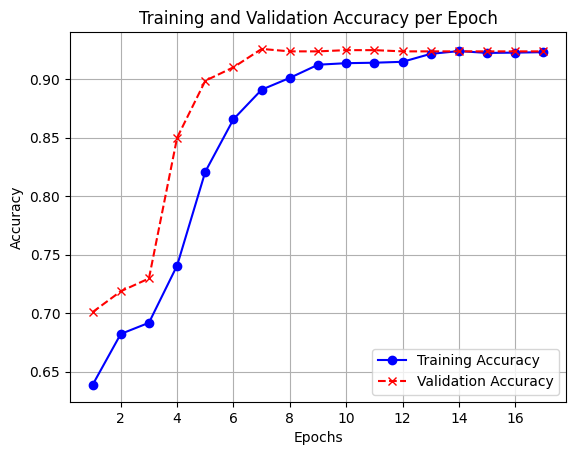

In [27]:
import matplotlib.pyplot as plt

train_acc, val_acc = model.get_train_acc()



x = range(1, len(train_acc) + 1)

# Plot training accuracy
plt.plot(x, train_acc, label='Training Accuracy', color='blue', linestyle='-', marker='o')

# Plot validation accuracy
plt.plot(x, val_acc, label='Validation Accuracy', color='red', linestyle='--', marker='x')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy per Epoch')

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

Predictions on Test Data

In [28]:
# do predictions on the test data 

In [32]:
model.predict_instance('midis/882.mid', 'midis/4220.mid')

[True]

In [30]:
test_preds = model.predict(dataroot2 + "/test.json", "predictions2.json", processed_data=processed_test_data)

Running predictions...
Predictions written to predictions2.json
Prediction process completed.
